In [100]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [93]:
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
rank_to_index = {rank: i for i, rank in enumerate(ranks)}
rank_len = len(ranks)

#Helper functions for data processing
def card_to_vec(card):
    raw_rank = card[:-1]
    one_hot_vector = [0] * rank_len
    one_hot_vector[rank_to_index[raw_rank]] = 1
    return one_hot_vector

def hand_to_list(hand):
    '''Takes hand like KH-AC and outputs list of card numbers'''
    hand_list_1 = hand.split("-")
    hand_list_2 = [card_to_vec(card) for card in hand_list_1]
    return hand_list_2

result_mapping = {
    'hit' : 0,
    'stand' : 1,
    'double down' : 2
}

batch_size = 32

# Defining Dataset Class
class Blackjack_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [94]:
split_or_not_raw_df = pd.read_csv('CSVs/split_or_not.csv')

In [95]:
sn_train_df, sn_test_df = train_test_split(split_or_not_raw_df, test_size=0.2)

def clean_up(dataframe_raw):
    # Cleaned split_or_not
    dataframe_raw['dealer_upcard'] = dataframe_raw['dealer_upcard'].apply(card_to_vec)
    dataframe_raw['player_hand'] = dataframe_raw['player_hand'].apply(hand_to_list)
    dataframe_raw['player_hand'] = dataframe_raw['player_hand'].apply(lambda hand: hand[0])
    dataframe_clean = dataframe_raw.rename(columns = {'player_hand':'player_upcard'})

    # Turning into tensor matrices
    # split_or_not
    x1 = torch.tensor(dataframe_clean['player_upcard'].to_list(), dtype=torch.float32)
    x2 = torch.tensor(dataframe_clean['dealer_upcard'].to_list(), dtype=torch.float32)
    y = torch.tensor(dataframe_clean['result'].values, dtype=torch.float32).view(-1,1)

    X = torch.cat([x1,x2], dim=1)

    return Blackjack_Dataset(X,y)

sn_train_dataset = clean_up(sn_train_df)
sn_test_dataset = clean_up(sn_test_df)

sn_train_dataloader = DataLoader(sn_train_dataset, batch_size=batch_size, shuffle=True)
sn_test_dataloader = DataLoader(sn_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    for batch, (X,y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Printing Training Update on every 100th batch
        if (batch + 1) % 100 == 0: 
            loss = loss.item()
            current = batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        if batch == (len(dataloader) - 1):
            train_losses.append(loss.item())


test_losses = []
test_accs = []

def test_loop(dataloader, model, loss_fn):
    #Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    #Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True

    with torch.no_grad():
        for X, y in dataloader: 
            pred = model(X)
            probs = torch.sigmoid(pred)
            preds = (probs >= 0.5).float()
            correct += (preds.view(-1) == y.view(-1)).float().sum()
            test_loss += loss_fn(pred, y).item()


    test_loss /= num_batches
    correct /= size 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    test_accs.append(100*correct)
    test_losses.append(test_loss)

In [117]:
class sn_NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

sn_model = sn_NeuralNetwork()

learning_rate = 0.01 
epochs = 20

loss_fn = nn.BCEWithLogitsLoss()
sn_optimizer = torch.optim.SGD(sn_model.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
test_losses = []
test_accs = []

for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------")
    train_loop(sn_train_dataloader, sn_model, loss_fn, sn_optimizer)
    test_loop(sn_test_dataloader, sn_model, loss_fn)
print("Done!")

Epoch 1
---------------------------
loss: 0.676723  [ 3200/141921]
loss: 0.673735  [ 6400/141921]
loss: 0.659317  [ 9600/141921]
loss: 0.628644  [12800/141921]
loss: 0.686802  [16000/141921]
loss: 0.639116  [19200/141921]
loss: 0.619448  [22400/141921]
loss: 0.630641  [25600/141921]
loss: 0.542209  [28800/141921]
loss: 0.622603  [32000/141921]
loss: 0.649116  [35200/141921]
loss: 0.610744  [38400/141921]
loss: 0.600289  [41600/141921]
loss: 0.642435  [44800/141921]
loss: 0.619716  [48000/141921]
loss: 0.549594  [51200/141921]
loss: 0.723703  [54400/141921]
loss: 0.545658  [57600/141921]
loss: 0.562472  [60800/141921]
loss: 0.460262  [64000/141921]
loss: 0.488512  [67200/141921]
loss: 0.376890  [70400/141921]
loss: 0.340983  [73600/141921]
loss: 0.380393  [76800/141921]
loss: 0.279191  [80000/141921]
loss: 0.251662  [83200/141921]
loss: 0.160243  [86400/141921]
loss: 0.139426  [89600/141921]
loss: 0.164974  [92800/141921]
loss: 0.113875  [96000/141921]
loss: 0.106580  [99200/141921]
los

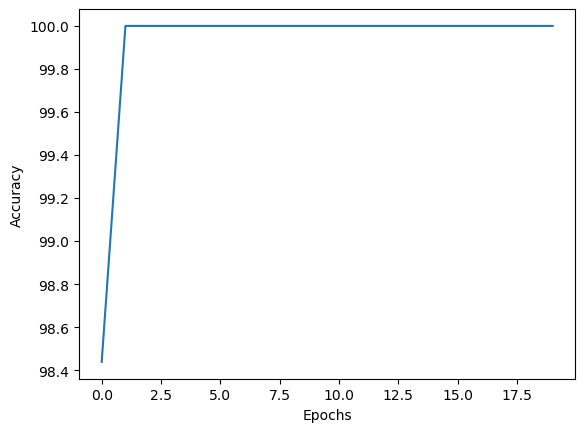

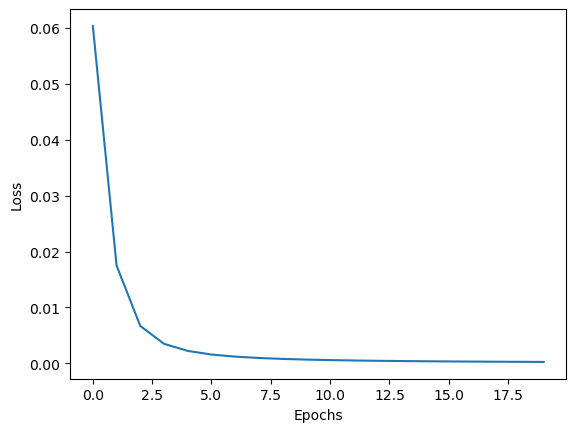

In [119]:
plt.plot(test_accs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(test_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

*Best Performance*

dataset size = 177,403
train/test split = 80/20

learning rate = 0.01
epochs = 20
batch_size = 32

Accuracy = 100% (by epoch 2)
Loss = 0.000232 (0.017500 at 2)


In [120]:
model = sn_NeuralNetwork()
torch.save(model, "sn_imit_nn.pt")